# Roosevelt National Forest of northern Colorado Competition

In this experiment we will apply some classifiers based on trees and then stack them all together to find out a good classifier

Ensemble Methods: RF, AdaBoost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

%matplotlib inline

In [3]:
# Global parameters
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH


## Read training and test data

In [4]:
# Reading the csv file with the whole dataset
data = pd.read_csv(train_path+'\\train.csv', sep=',', header=0, index_col=0)
# Train data, erasing label column
train_data = data.drop('Cover_Type', axis=1)
train_label = data[['Cover_Type']]
# Read the test data
test_data = pd.read_csv(test_path+'\\test.csv', sep=',', header=0, index_col=0)

## Data preprocessing

### Global variables

In [5]:
# Define some groups of columns based on  type
var_numeric = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']
# There are no categoric variables to transfomr
var_categoric = []

# Numerical columns with missing values
# In our first approach, no missing values to consider
columns_nan=[]

#Defining some relevant group of columns
# Columns to be ingored for classification
# Soil Type 7,8, 15 y 25
columns_to_ignore = ['Soil_Type7','Soil_Type8','Soil_Type15','Soil_Type25']

num_columns_nan=[i for i in columns_nan if i not in columns_to_ignore]
enconde_cols_name=[i for i in var_categoric if i not in columns_to_ignore]

### Feature engineering and selection

In [6]:
# Horizontal to roadways and to Fire poins are very simila recpect to arget variable so lets drop horizontal to roadways
# Horizontal and vertical to hidrology are correlated, lets drop vertical
# Drop soil types where the number of rows are very low: 9, 21, 27, 28, 36
# Outliers: 
columns_unselect=['Soil_Type9','Soil_Type21','Soil_Type27','Soil_Type28','Soil_Type36']


In [7]:
# Manipulate and transform columns in dataframe to be used in the next stages

# Delete non relevant columns
train_data.drop(columns_to_ignore+columns_unselect, axis=1,inplace=True)
test_data.drop(columns_to_ignore+columns_unselect, axis=1,inplace=True)

#Filling na values in columns
#Not neccesary at this moment

#Dealing with ourliers or data errors
#Not neccesary at this moment

# Define columns to fill nan values and categorial columns to one-hot-encode 
columns_nan=[train_df.columns.tolist().index(i) for i in num_columns_nan]
columns_enconde=[train_df.columns.tolist().index(i) for i in enconde_cols_name]


In [8]:
print('Train data: ',train_data.shape)
print('Train labels: ',train_label.shape)
print('Test data: ',test_data.shape)

Train data:  (15120, 45)
Train labels:  (15120, 1)
Test data:  (565892, 45)


## Preparing the data for the algorithm

In [10]:
# Tranform to numpy array
X = train_data.values.astype('float64')
y = train_label.values.ravel()
test_ds= test_data.values.astype('float64')

#Convertimos todos los valores a float incluida la columna boolean
# To avoid error in the imputer action if it was neccesary
#X= np.vstack(X[:, :]).astype(np.float)

print('X: ', X.shape)
print('y: ', y.shape)
print('test: ', test_ds.shape)
#X Shape 500,000 x 8

X:  (15120, 45)
y:  (15120,)
test:  (565892, 45)


In [16]:
X

array([[2.596e+03, 5.100e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.590e+03, 5.600e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.804e+03, 1.390e+02, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.492e+03, 1.340e+02, 2.500e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.487e+03, 1.670e+02, 2.800e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.475e+03, 1.970e+02, 3.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

## Building and training an algorithm

### Creating the train and test datasets

In [51]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
test_ds= sc.transform(test_ds)

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)
print('Test Shape:', test_ds.shape)

X Train Shape: (9072, 45)
X Test Shape: (6048, 45)
Test Shape: (565892, 45)


In [53]:
X_train_l2 = pd.DataFrame(columns=['RF'])
X_train_l2.info

<bound method DataFrame.info of Empty DataFrame
Columns: [RF]
Index: []>

### Train the algorithm: Random Forest

In [54]:
# Fitting Decision Tree to the Training set
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameter_candidates = [{'n_estimators': [50, 100, 125]}]

classifier = GridSearchCV(estimator=RandomForestClassifier(criterion = 'entropy', max_depth=None,min_samples_split=2,
                                                           min_samples_leaf=1, max_leaf_nodes=None,random_state = 0),
                          param_grid=parameter_candidates, scoring='accuracy', n_jobs=-1, cv=5, verbose=1, refit=True, 
                          return_train_score=True)

# Train the classifier on data1's feature and target data
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 125]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [55]:
#Show the results of the hyperparameter tunning
print(classifier.best_params_)
print(classifier.best_estimator_)


{'n_estimators': 125}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [35]:
from sklearn.model_selection import StratifiedKFold

y_preds, y_actual=[],[]
for train_index, test_index in StratifiedKFold(n_splits=10, random_state=1234, shuffle=True).split(X, y):
    y_preds.append(classifier.best_estimator_.predict_proba(X[test_index]))
    y_actual.append(y[test_index])



In [57]:
from sklearn.metrics import accuracy_score

predictions=classifier.best_estimator_.predict(X_test)
print(predictions.shape)
predictions_test = classifier.best_estimator_.predict(test_ds)
print(predictions_test.shape)
print(round(accuracy_score(y_test, predictions),4))

X_train_l2['RF'] = predictions

(6048,)
(565892,)
0.8466


,RF
0,4
1,4
2,4
3,4
4,4
5,1
6,4
7,7
8,1
9,7


### Train the algorithm: Decision Tree

In [59]:
# Fitting Decision Tree to the Training set
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion = 'entropy',max_depth=None,min_samples_split=2, min_samples_leaf=1,
                                    max_leaf_nodes=None,max_features='auto', random_state = 0)

classifier.fit(X_train, y_train)
#Show the results of the hyperparameter tunning
predictions=classifier.predict(X_test)
print(predictions.shape)
predictions_test = classifier.predict(test_ds)
print(predictions_test.shape)
print(round(accuracy_score(y_test, predictions),4))

X_train_l2['DT'] = predictions

(6048,)
(565892,)
0.7235


### Train the algorithm: AdaBoosted Decision Tree

In [60]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the base estimator for the Adaboost algorithm
base_classifier = DecisionTreeClassifier(criterion ='entropy',max_depth=None, min_samples_split=2,min_samples_leaf=2,
                                                       max_leaf_nodes=None,random_state = 0)

parameter_candidates = [{'n_estimators': [50, 100, 125], 'learning_rate': [0.25, 0.5, 1.]}]

classifier = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=base_classifier,random_state=0),
                          param_grid=parameter_candidates, scoring='accuracy', n_jobs=-1, cv=5, verbose=1, refit=True, 
                          return_train_score=True)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 125], 'learning_rate': [0.25, 0.5, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [61]:
#Show the results of the hyperparameter tunning
print(classifier.best_params_)
print(classifier.best_estimator_)

predictions=classifier.best_estimator_.predict(X_test)
print(predictions.shape)
predictions_test = classifier.best_estimator_.predict(test_ds)
print(predictions_test.shape)
print(round(accuracy_score(y_test, predictions),4))

X_train_l2['AB'] = predictions

{'learning_rate': 0.25, 'n_estimators': 100}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=0.25, n_estimators=100, random_state=0)
(6048,)
(565892,)
0.8522


### Train the algorithm: Gradient Boosting Classifier

In [62]:
# Fitting Decision Tree to the Training set
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.tree import DecisionTreeClassifier
#classifier = GradientBoostingClassifier(n_estimators=100,learning_rate=0.5,max_depth=15,
#              min_samples_leaf=1, min_samples_split=2,random_state=0,verbose=1)
#Hyperparameter tuning with Grid Search
parameter_candidates = [{'n_estimators': [50, 100, 125], 'learning_rate': [0.5,0.2,0.1], 'max_depth':[5,10,None]}]

classifier = GridSearchCV(estimator=GradientBoostingClassifier(min_samples_leaf=1, min_samples_split=2,random_state=0,verbose=1),
                          param_grid=parameter_candidates, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Train the classifier on data1's feature and target data
classifier.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 20.4min finished


      Iter       Train Loss   Remaining Time 
         1       10620.1119            1.40m
         2        7733.7413            1.44m
         3        5869.8905            1.46m
         4        4594.7696            1.47m
         5        3625.5944            1.47m
         6        2919.8230            1.46m
         7        2391.3320            1.45m
         8        1977.9951            1.45m
         9        1640.1807            1.44m
        10        1374.9496            1.42m
        20         359.2368            1.29m
        30         141.6159            1.09m
        40          57.6664           54.84s
        50          24.8450           45.95s
        60          11.6845           37.46s
        70           6.2602           29.63s
        80           4.1854           22.43s
        90           3.4764           15.99s
       100           3.0524           10.53s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 125], 'learning_rate': [0.5, 0.2, 0.1], 'max_depth': [5, 10, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [63]:
#Show the results of the hyperparameter tunning
print(classifier.best_params_)
print(classifier.best_estimator_)

predictions=classifier.best_estimator_.predict(X_test)
print(predictions.shape)
predictions_test = classifier.best_estimator_.predict(test_ds)
print(predictions_test.shape)
print(round(accuracy_score(y_test, predictions),4))

X_train_l2['GB'] = predictions

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 125}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)
(6048,)
(565892,)
0.8476


In [41]:
# Scoring the model by Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean_score = accuracies.mean()
std_score = accuracies.std()
print('Mean: ',mean_score)
print('Std: ',std_score)

Mean:  0.8479719984497024
Std:  0.00590787992349919


In [64]:
# Fitting Decision Tree to the Training set
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

parameter_candidates = [{'n_estimators': [50, 100, 125]}]

classifier = GridSearchCV(estimator=ExtraTreesClassifier(criterion = 'entropy', max_depth=None,min_samples_split=2,
                                                           min_samples_leaf=1, max_leaf_nodes=None,random_state = 0),
                          param_grid=parameter_candidates, scoring='accuracy', n_jobs=-1, cv=5, verbose=1, refit=True, 
                          return_train_score=True)

# Train the classifier on data1's feature and target data
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 125]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [65]:
#Show the results of the hyperparameter tunning
print(classifier.best_params_)
print(classifier.best_estimator_)

predictions=classifier.best_estimator_.predict(X_test)
print(predictions.shape)
predictions_test = classifier.best_estimator_.predict(test_ds)
print(predictions_test.shape)
print(round(accuracy_score(y_test, predictions),4))

X_train_l2['ET'] = predictions

{'n_estimators': 125}
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
(6048,)
(565892,)
0.848


In [67]:
# Fitting Decision Tree to the Training set
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

parameter_candidates = [{'max_iter': [50, 100, 125], 'learning_rate': [0.5,0.2,0.1]}]

classifier = GridSearchCV(estimator=GradientBoostingClassifier(min_samples_leaf=20, random_state=0,verbose=1),
                          param_grid=parameter_candidates, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Train the classifier on data1's feature and target data
classifier.fit(X_train, y_train)

ModuleNotFoundError: No module named 'sklearn.experimental'

### Scoring and evaluating the model

In [32]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ',cm)

acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)


Confusion Matrix:  [[415  91   1   0   7   1  30]
 [ 91 368  15   0  38   7   6]
 [  0   1 457  25  10  58   0]
 [  0   0   9 522   0  13   0]
 [  4  27   5   0 485   4   0]
 [  0   6  56   7   9 481   0]
 [ 17   2   0   0   0   0 512]]
Accuracy:  0.8571428571428571


## Showing the results

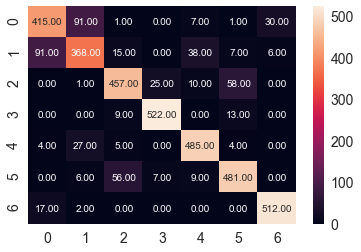

In [33]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='.2f',annot_kws={"size": 10})# font size

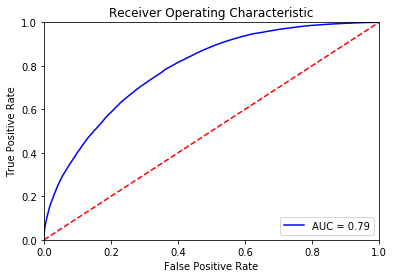

In [14]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Building and training a XGBoosted Classifier

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### Simple train and score 

In [15]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.87%


### Use early stopping to prevent overfiting

In [17]:
# fit model on training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-mlogloss:1.81184
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.70536
[2]	validation_0-mlogloss:1.60817
[3]	validation_0-mlogloss:1.52564
[4]	validation_0-mlogloss:1.45405
[5]	validation_0-mlogloss:1.39166
[6]	validation_0-mlogloss:1.33615
[7]	validation_0-mlogloss:1.28701
[8]	validation_0-mlogloss:1.24252
[9]	validation_0-mlogloss:1.20185
[10]	validation_0-mlogloss:1.16566
[11]	validation_0-mlogloss:1.13161
[12]	validation_0-mlogloss:1.10187
[13]	validation_0-mlogloss:1.07309
[14]	validation_0-mlogloss:1.04709
[15]	validation_0-mlogloss:1.02314
[16]	validation_0-mlogloss:1.00087
[17]	validation_0-mlogloss:0.979585
[18]	validation_0-mlogloss:0.961162
[19]	validation_0-mlogloss:0.944345
[20]	validation_0-mlogloss:0.927887
[21]	validation_0-mlogloss:0.912448
[22]	validation_0-mlogloss:0.897978
[23]	validation_0-mlogloss:0.884746
[24]	validation_0-mlogloss:0.872194
[25]	validation_0-mlogloss:0.86135
[26]	validation_0-mlogl

In [18]:
print(model.feature_importances_)

[0.11665306 0.00693619 0.00625086 0.02033894 0.01081294 0.01420751
 0.02833169 0.01276159 0.00985048 0.01355531 0.02229558 0.00711938
 0.0211423  0.0933722  0.0066583  0.01004208 0.05041707 0.02392996
 0.01250993 0.01098667 0.         0.04807513 0.00604195 0.0339755
 0.02577008 0.00442801 0.00190394 0.01292626 0.         0.
 0.00368925 0.         0.02352204 0.01841108 0.00862217 0.
 0.         0.         0.02629612 0.19710079 0.00738642 0.01835677
 0.01105236 0.00128078 0.00456985 0.         0.         0.01546755
 0.02246774 0.01048422]


<Figure size 720x1440 with 0 Axes>

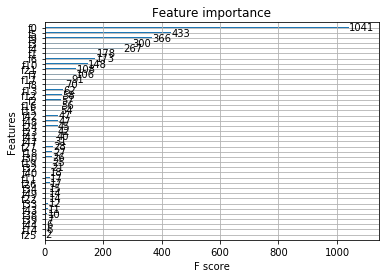

In [23]:
from xgboost import plot_importance
plt.figure(figsize=(10,20))
plot_importance(model)
plt.show()

### Hyperparameter tunning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()

n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 31.3min finished


In [27]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.368889 using {'max_depth': 8, 'n_estimators': 200}
-0.792418 (0.019440) with: {'max_depth': 2, 'n_estimators': 50}
-0.682119 (0.021245) with: {'max_depth': 2, 'n_estimators': 100}
-0.633146 (0.021427) with: {'max_depth': 2, 'n_estimators': 150}
-0.602118 (0.021040) with: {'max_depth': 2, 'n_estimators': 200}
-0.642494 (0.020331) with: {'max_depth': 4, 'n_estimators': 50}
-0.543494 (0.020418) with: {'max_depth': 4, 'n_estimators': 100}
-0.495503 (0.019557) with: {'max_depth': 4, 'n_estimators': 150}
-0.468006 (0.020418) with: {'max_depth': 4, 'n_estimators': 200}
-0.539366 (0.019385) with: {'max_depth': 6, 'n_estimators': 50}
-0.454329 (0.020631) with: {'max_depth': 6, 'n_estimators': 100}
-0.417578 (0.024626) with: {'max_depth': 6, 'n_estimators': 150}
-0.397278 (0.024947) with: {'max_depth': 6, 'n_estimators': 200}
-0.473768 (0.020015) with: {'max_depth': 8, 'n_estimators': 50}
-0.402162 (0.022094) with: {'max_depth': 8, 'n_estimators': 100}
-0.378367 (0.025373) with: {'max_d

In [70]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


In [1]:
from lightgbm import LGBMModel,LGBMClassifier

ModuleNotFoundError: No module named 'lightgbm'